In [1]:
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
from skimage import data
from skimage import filters
from skimage import exposure

from sklearn.decomposition import PCA
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import explained_variance_score
import cv2

import keras
from tensorflow.keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Input 
from tensorflow.keras.optimizers import RMSprop
# Granulometry
from skimage import data
from skimage import filters
from skimage import exposure
#labelling
from skimage.morphology import label

In [2]:
class Granulometry:
    def __init__(self, minDisc=1, maxDisc=30, growth=1):
        self.sizes = range(minDisc, maxDisc, growth)
        nb = int((maxDisc - minDisc) / growth) 
        self.granulo = np.zeros(nb)
        
    def disk_structure(self, n):
        struct = np.zeros((2 * n + 1, 2 * n + 1))
        x, y = np.indices((2 * n + 1, 2 * n + 1))
        mask = (x - n)**2 + (y - n)**2 <= n**2
        struct[mask] = 1
        return struct.astype(bool)


    def granulometry(self, data):
        s = max(data.shape)
        if self.sizes is None:
            self.sizes = range(1, s/2, 2)
        self.granulo = [ndimage.binary_opening(data, structure=self.disk_structure(n)).sum() for n in self.sizes]
        return self.granulo
    
    def granulometry_with_step(self, data):
        s = max(data.shape)
        if self.sizes is None:
            self.sizes = range(1, s/2, 2)

        i = 0
        for n in self.sizes:
            print(i)
            opened = ndimage.binary_opening(data, structure=self.disk_structure(n))
            self.granulo[i] = opened.sum()
            plt.imshow(data, cmap=plt.cm.gray)
            plt.contour(opened, [0.5], colors='b', linewidths=2)
            plt.show()
            i += 1
            
        return self.granulo
    
    def plot_granulo(self):
        plt.plot(self.sizes, self.granulo, 'ok', ms=8)
        plt.show()
    


In [3]:
def minMaxRescale(x):
    max_val = np.max(x)
    min_val = np.min(x)
    return (x - min_val)/(max_val - min_val)

def rescale(x):
    return x / 255.

In [4]:
PATH = "DatasetReal/"

classes = {}
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))

for directory in os.listdir(PATH):
    print(directory)
    
    classes[directory] = {}
    
    for file in os.listdir(PATH+directory):
        
        image = cv2.imread(PATH+directory+"/"+file, 0)
        erode = cv2.erode(image,kernel)
        image = image - erode

        image = cv2.cv2.resize(image, (320,256))

        data = rescale(image)
        
        MCL = file.split('_')[1]
        
        if MCL in classes[directory]:
            classes[directory][MCL].append(data)
        else:
            classes[directory][MCL] = []
            classes[directory][MCL].append(data)

1.198
0.677
0.735
2.316
1.710
2.277
1.161
2.176
0.810
0.725


In [5]:
nb_mcl = 1
nb_ra  = len(classes)

gran = Granulometry(1, 20, 2)

X = []
Ra = []
MCL = []
Granulo = []
nbPoint = []

for key_ra, ra in classes.items():
    for key_mcl, mcl in classes[key_ra].items():
        for picture in mcl:
            
            image = picture
            #image preproc
            val = filters.threshold_otsu(image)
            image_otsu = image < val
            # granulo
            Granulo.append(gran.granulometry(image_otsu))
            #labeling
            label_image = label(image_otsu, connectivity=2)
            np_point = len(np.unique(label_image))
            nbPoint.append(np_point)
            
            X.append(picture.flatten())
            Ra.append(key_ra)
            MCL.append(key_mcl)
            
data = {'X': X,
        'class': Ra,
        'MCL': MCL,
        'granulo': Granulo,
        'nbPoint': nbPoint
        }

df = pd.DataFrame(data)

print (df)

                                                     X  class  MCL  \
0    [0.00392156862745098, 0.0196078431372549, 0.02...  1.198  600   
1    [0.01568627450980392, 0.023529411764705882, 0....  1.198  600   
2    [0.0196078431372549, 0.027450980392156862, 0.0...  1.198  600   
3    [0.01568627450980392, 0.03137254901960784, 0.0...  1.198  600   
4    [0.0196078431372549, 0.027450980392156862, 0.0...  1.198  600   
..                                                 ...    ...  ...   
149  [0.011764705882352941, 0.0196078431372549, 0.0...  0.725  600   
150  [0.0196078431372549, 0.01568627450980392, 0.03...  0.725  600   
151  [0.01568627450980392, 0.023529411764705882, 0....  0.725  600   
152  [0.011764705882352941, 0.011764705882352941, 0...  0.725  600   
153  [0.00784313725490196, 0.0196078431372549, 0.03...  0.725  600   

                                       granulo  nbPoint  
0      [36964, 6910, 739, 0, 0, 0, 0, 0, 0, 0]      257  
1          [11027, 29, 0, 0, 0, 0, 0, 0, 0,

In [6]:

X2 = np.stack(df['granulo'].to_numpy())
X3 = np.stack(df['nbPoint'].to_numpy())
y = df['class'].to_numpy()

# for classification
#enc = OneHotEncoder()
#y = enc.fit_transform(y.reshape(-1,1)).toarray()

y = y.astype(float)

X2 = minMaxRescale(X2)
X3 = minMaxRescale(X3).reshape(-1,1)
X = np.append(X2,X3,axis=1)
#X = np.append(X,X3,axis=1)
pca = PCA(n_components=3)
X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [7]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(123, 3)
(123, 1)
(31, 3)
(31, 1)


# MLP

In [8]:
BATCH_SIZE = 64
def define_model():
    NB_HIDDEN_NEURON = 10

    model = Sequential() 
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(NB_HIDDEN_NEURON, kernel_initializer = 'glorot_uniform', activation = 'relu'))  
    model.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'linear'))
    model.summary()
    return model

FOLD N: 0
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                40        
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
2/2 [==============================] - 0s 119ms/step - loss: 2.4416 - mean_absolute_error: 1.3527 - val_loss: 2.9259 - val_mean_absolute_error: 1.4949
Epoch 2/200
2/2 [==============================] - 0s 37ms/step - loss: 2.3524 - mean_absolute_error: 1.3217 - val_loss: 2.8460 - val_mean_absolute_error: 1.4696
Epoch 3/200
2/2 [==============================] - 0s 27ms/step - loss: 2.2921 - mean_absolute_error: 1.2996 - val_loss

2/2 [==============================] - 0s 28ms/step - loss: 0.3182 - mean_absolute_error: 0.4344 - val_loss: 0.2938 - val_mean_absolute_error: 0.4404
Epoch 98/200
2/2 [==============================] - 0s 29ms/step - loss: 0.3089 - mean_absolute_error: 0.4279 - val_loss: 0.2829 - val_mean_absolute_error: 0.4324
Epoch 99/200
2/2 [==============================] - 0s 28ms/step - loss: 0.2998 - mean_absolute_error: 0.4216 - val_loss: 0.2722 - val_mean_absolute_error: 0.4242
Epoch 100/200
2/2 [==============================] - 0s 26ms/step - loss: 0.2912 - mean_absolute_error: 0.4155 - val_loss: 0.2622 - val_mean_absolute_error: 0.4167
Epoch 101/200
2/2 [==============================] - 0s 35ms/step - loss: 0.2825 - mean_absolute_error: 0.4095 - val_loss: 0.2519 - val_mean_absolute_error: 0.4087
Epoch 102/200
2/2 [==============================] - 0s 37ms/step - loss: 0.2738 - mean_absolute_error: 0.4037 - val_loss: 0.2417 - val_mean_absolute_error: 0.3993
Epoch 103/200
2/2 [=============

2/2 [==============================] - 0s 31ms/step - loss: 0.0898 - mean_absolute_error: 0.2272 - val_loss: 0.0680 - val_mean_absolute_error: 0.2023
Epoch 148/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0891 - mean_absolute_error: 0.2257 - val_loss: 0.0679 - val_mean_absolute_error: 0.2011
Epoch 149/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0886 - mean_absolute_error: 0.2248 - val_loss: 0.0679 - val_mean_absolute_error: 0.1992
Epoch 150/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0881 - mean_absolute_error: 0.2228 - val_loss: 0.0678 - val_mean_absolute_error: 0.1978
Epoch 151/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0877 - mean_absolute_error: 0.2220 - val_loss: 0.0681 - val_mean_absolute_error: 0.1962
Epoch 152/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0874 - mean_absolute_error: 0.2218 - val_loss: 0.0678 - val_mean_absolute_error: 0.1947
Epoch 153/200
2/2 [===========

2/2 [==============================] - 0s 29ms/step - loss: 0.0771 - mean_absolute_error: 0.2128 - val_loss: 0.0571 - val_mean_absolute_error: 0.1779
Epoch 198/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0771 - mean_absolute_error: 0.2121 - val_loss: 0.0572 - val_mean_absolute_error: 0.1774
Epoch 199/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0769 - mean_absolute_error: 0.2131 - val_loss: 0.0567 - val_mean_absolute_error: 0.1767
Epoch 200/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0767 - mean_absolute_error: 0.2124 - val_loss: 0.0568 - val_mean_absolute_error: 0.1760
FOLD N: 1
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                40        
                                                                 
 dense_9 (Dense)             (None, 1)                 11     

2/2 [==============================] - 0s 31ms/step - loss: 0.9219 - mean_absolute_error: 0.7223 - val_loss: 0.8254 - val_mean_absolute_error: 0.6347
Epoch 94/200
2/2 [==============================] - 0s 27ms/step - loss: 0.9138 - mean_absolute_error: 0.7189 - val_loss: 0.8184 - val_mean_absolute_error: 0.6325
Epoch 95/200
2/2 [==============================] - 0s 31ms/step - loss: 0.9056 - mean_absolute_error: 0.7160 - val_loss: 0.8118 - val_mean_absolute_error: 0.6303
Epoch 96/200
2/2 [==============================] - 0s 32ms/step - loss: 0.8973 - mean_absolute_error: 0.7118 - val_loss: 0.8050 - val_mean_absolute_error: 0.6281
Epoch 97/200
2/2 [==============================] - 0s 30ms/step - loss: 0.8889 - mean_absolute_error: 0.7087 - val_loss: 0.7980 - val_mean_absolute_error: 0.6259
Epoch 98/200
2/2 [==============================] - 0s 27ms/step - loss: 0.8809 - mean_absolute_error: 0.7054 - val_loss: 0.7914 - val_mean_absolute_error: 0.6237
Epoch 99/200
2/2 [=================

2/2 [==============================] - 0s 35ms/step - loss: 0.5537 - mean_absolute_error: 0.5600 - val_loss: 0.5105 - val_mean_absolute_error: 0.5306
Epoch 144/200
2/2 [==============================] - 0s 33ms/step - loss: 0.5473 - mean_absolute_error: 0.5568 - val_loss: 0.5050 - val_mean_absolute_error: 0.5282
Epoch 145/200
2/2 [==============================] - 0s 35ms/step - loss: 0.5409 - mean_absolute_error: 0.5525 - val_loss: 0.4992 - val_mean_absolute_error: 0.5262
Epoch 146/200
2/2 [==============================] - 0s 33ms/step - loss: 0.5346 - mean_absolute_error: 0.5496 - val_loss: 0.4937 - val_mean_absolute_error: 0.5243
Epoch 147/200
2/2 [==============================] - 0s 27ms/step - loss: 0.5282 - mean_absolute_error: 0.5470 - val_loss: 0.4882 - val_mean_absolute_error: 0.5217
Epoch 148/200
2/2 [==============================] - 0s 31ms/step - loss: 0.5219 - mean_absolute_error: 0.5428 - val_loss: 0.4826 - val_mean_absolute_error: 0.5196
Epoch 149/200
2/2 [===========

2/2 [==============================] - 0s 29ms/step - loss: 0.2800 - mean_absolute_error: 0.4052 - val_loss: 0.2617 - val_mean_absolute_error: 0.4135
Epoch 194/200
2/2 [==============================] - 0s 25ms/step - loss: 0.2759 - mean_absolute_error: 0.4024 - val_loss: 0.2576 - val_mean_absolute_error: 0.4107
Epoch 195/200
2/2 [==============================] - 0s 26ms/step - loss: 0.2717 - mean_absolute_error: 0.3992 - val_loss: 0.2535 - val_mean_absolute_error: 0.4078
Epoch 196/200
2/2 [==============================] - 0s 27ms/step - loss: 0.2677 - mean_absolute_error: 0.3967 - val_loss: 0.2493 - val_mean_absolute_error: 0.4052
Epoch 197/200
2/2 [==============================] - 0s 27ms/step - loss: 0.2631 - mean_absolute_error: 0.3928 - val_loss: 0.2451 - val_mean_absolute_error: 0.4028
Epoch 198/200
2/2 [==============================] - 0s 28ms/step - loss: 0.2588 - mean_absolute_error: 0.3894 - val_loss: 0.2410 - val_mean_absolute_error: 0.4009
Epoch 199/200
2/2 [===========

2/2 [==============================] - 0s 27ms/step - loss: 0.3462 - mean_absolute_error: 0.4556 - val_loss: 0.5770 - val_mean_absolute_error: 0.6500
Epoch 90/200
2/2 [==============================] - 0s 28ms/step - loss: 0.3391 - mean_absolute_error: 0.4515 - val_loss: 0.5663 - val_mean_absolute_error: 0.6435
Epoch 91/200
2/2 [==============================] - 0s 25ms/step - loss: 0.3316 - mean_absolute_error: 0.4458 - val_loss: 0.5543 - val_mean_absolute_error: 0.6366
Epoch 92/200
2/2 [==============================] - 0s 28ms/step - loss: 0.3241 - mean_absolute_error: 0.4418 - val_loss: 0.5435 - val_mean_absolute_error: 0.6299
Epoch 93/200
2/2 [==============================] - 0s 27ms/step - loss: 0.3168 - mean_absolute_error: 0.4370 - val_loss: 0.5316 - val_mean_absolute_error: 0.6227
Epoch 94/200
2/2 [==============================] - 0s 28ms/step - loss: 0.3093 - mean_absolute_error: 0.4328 - val_loss: 0.5215 - val_mean_absolute_error: 0.6161
Epoch 95/200
2/2 [=================

2/2 [==============================] - 0s 29ms/step - loss: 0.0698 - mean_absolute_error: 0.2026 - val_loss: 0.1373 - val_mean_absolute_error: 0.2288
Epoch 190/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0699 - mean_absolute_error: 0.2022 - val_loss: 0.1375 - val_mean_absolute_error: 0.2291
Epoch 191/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0697 - mean_absolute_error: 0.2017 - val_loss: 0.1369 - val_mean_absolute_error: 0.2291
Epoch 192/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0697 - mean_absolute_error: 0.2016 - val_loss: 0.1365 - val_mean_absolute_error: 0.2294
Epoch 193/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0694 - mean_absolute_error: 0.2026 - val_loss: 0.1363 - val_mean_absolute_error: 0.2284
Epoch 194/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0695 - mean_absolute_error: 0.2011 - val_loss: 0.1360 - val_mean_absolute_error: 0.2297
Epoch 195/200
2/2 [===========

2/2 [==============================] - 0s 29ms/step - loss: 1.8224 - mean_absolute_error: 1.0781 - val_loss: 0.8644 - val_mean_absolute_error: 0.6522
Epoch 86/200
2/2 [==============================] - 0s 27ms/step - loss: 1.8128 - mean_absolute_error: 1.0729 - val_loss: 0.8586 - val_mean_absolute_error: 0.6467
Epoch 87/200
2/2 [==============================] - 0s 24ms/step - loss: 1.8034 - mean_absolute_error: 1.0675 - val_loss: 0.8530 - val_mean_absolute_error: 0.6412
Epoch 88/200
2/2 [==============================] - 0s 27ms/step - loss: 1.7944 - mean_absolute_error: 1.0624 - val_loss: 0.8475 - val_mean_absolute_error: 0.6360
Epoch 89/200
2/2 [==============================] - 0s 28ms/step - loss: 1.7854 - mean_absolute_error: 1.0576 - val_loss: 0.8419 - val_mean_absolute_error: 0.6304
Epoch 90/200
2/2 [==============================] - 0s 28ms/step - loss: 1.7763 - mean_absolute_error: 1.0523 - val_loss: 0.8365 - val_mean_absolute_error: 0.6249
Epoch 91/200
2/2 [=================

2/2 [==============================] - 0s 53ms/step - loss: 1.3383 - mean_absolute_error: 0.8691 - val_loss: 0.6461 - val_mean_absolute_error: 0.5591
Epoch 186/200
2/2 [==============================] - 0s 28ms/step - loss: 1.3353 - mean_absolute_error: 0.8684 - val_loss: 0.6445 - val_mean_absolute_error: 0.5585
Epoch 187/200
2/2 [==============================] - 0s 30ms/step - loss: 1.3323 - mean_absolute_error: 0.8674 - val_loss: 0.6430 - val_mean_absolute_error: 0.5580
Epoch 188/200
2/2 [==============================] - 0s 27ms/step - loss: 1.3294 - mean_absolute_error: 0.8663 - val_loss: 0.6415 - val_mean_absolute_error: 0.5576
Epoch 189/200
2/2 [==============================] - 0s 27ms/step - loss: 1.3265 - mean_absolute_error: 0.8653 - val_loss: 0.6403 - val_mean_absolute_error: 0.5578
Epoch 190/200
2/2 [==============================] - 0s 28ms/step - loss: 1.3235 - mean_absolute_error: 0.8646 - val_loss: 0.6388 - val_mean_absolute_error: 0.5573
Epoch 191/200
2/2 [===========

2/2 [==============================] - 0s 34ms/step - loss: 0.6699 - mean_absolute_error: 0.6615 - val_loss: 0.7472 - val_mean_absolute_error: 0.7770
Epoch 77/200
2/2 [==============================] - 0s 29ms/step - loss: 0.6528 - mean_absolute_error: 0.6484 - val_loss: 0.7269 - val_mean_absolute_error: 0.7641
Epoch 78/200
2/2 [==============================] - 0s 31ms/step - loss: 0.6360 - mean_absolute_error: 0.6361 - val_loss: 0.7062 - val_mean_absolute_error: 0.7508
Epoch 79/200
2/2 [==============================] - 0s 26ms/step - loss: 0.6190 - mean_absolute_error: 0.6229 - val_loss: 0.6866 - val_mean_absolute_error: 0.7379
Epoch 80/200
2/2 [==============================] - 0s 29ms/step - loss: 0.6029 - mean_absolute_error: 0.6099 - val_loss: 0.6678 - val_mean_absolute_error: 0.7253
Epoch 81/200
2/2 [==============================] - 0s 29ms/step - loss: 0.5873 - mean_absolute_error: 0.5973 - val_loss: 0.6492 - val_mean_absolute_error: 0.7125
Epoch 82/200
2/2 [=================

2/2 [==============================] - 0s 43ms/step - loss: 0.0694 - mean_absolute_error: 0.2041 - val_loss: 0.0844 - val_mean_absolute_error: 0.2300
Epoch 177/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0690 - mean_absolute_error: 0.2003 - val_loss: 0.0838 - val_mean_absolute_error: 0.2297
Epoch 178/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0689 - mean_absolute_error: 0.2018 - val_loss: 0.0845 - val_mean_absolute_error: 0.2296
Epoch 179/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0688 - mean_absolute_error: 0.2000 - val_loss: 0.0843 - val_mean_absolute_error: 0.2294
Epoch 180/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0686 - mean_absolute_error: 0.2001 - val_loss: 0.0842 - val_mean_absolute_error: 0.2291
Epoch 181/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0690 - mean_absolute_error: 0.2020 - val_loss: 0.0848 - val_mean_absolute_error: 0.2291
Epoch 182/200
2/2 [===========

2/2 [==============================] - 0s 29ms/step - loss: 0.1989 - mean_absolute_error: 0.3444 - val_loss: 0.3660 - val_mean_absolute_error: 0.4201
Epoch 68/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1923 - mean_absolute_error: 0.3357 - val_loss: 0.3568 - val_mean_absolute_error: 0.4113
Epoch 69/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1857 - mean_absolute_error: 0.3270 - val_loss: 0.3483 - val_mean_absolute_error: 0.4027
Epoch 70/200
2/2 [==============================] - 0s 48ms/step - loss: 0.1796 - mean_absolute_error: 0.3180 - val_loss: 0.3402 - val_mean_absolute_error: 0.3942
Epoch 71/200
2/2 [==============================] - 0s 73ms/step - loss: 0.1739 - mean_absolute_error: 0.3101 - val_loss: 0.3325 - val_mean_absolute_error: 0.3859
Epoch 72/200
2/2 [==============================] - 0s 71ms/step - loss: 0.1684 - mean_absolute_error: 0.3019 - val_loss: 0.3250 - val_mean_absolute_error: 0.3775
Epoch 73/200
2/2 [=================

2/2 [==============================] - 0s 29ms/step - loss: 0.0787 - mean_absolute_error: 0.2100 - val_loss: 0.1627 - val_mean_absolute_error: 0.2722
Epoch 168/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0782 - mean_absolute_error: 0.2078 - val_loss: 0.1628 - val_mean_absolute_error: 0.2738
Epoch 169/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0781 - mean_absolute_error: 0.2083 - val_loss: 0.1628 - val_mean_absolute_error: 0.2747
Epoch 170/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0778 - mean_absolute_error: 0.2086 - val_loss: 0.1626 - val_mean_absolute_error: 0.2749
Epoch 171/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0777 - mean_absolute_error: 0.2088 - val_loss: 0.1618 - val_mean_absolute_error: 0.2739
Epoch 172/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0775 - mean_absolute_error: 0.2075 - val_loss: 0.1619 - val_mean_absolute_error: 0.2757
Epoch 173/200
2/2 [===========

Epoch 13/200
2/2 [==============================] - 0s 31ms/step - loss: 1.2537 - mean_absolute_error: 1.0218 - val_loss: 0.7658 - val_mean_absolute_error: 0.7989
Epoch 14/200
2/2 [==============================] - 0s 27ms/step - loss: 1.2244 - mean_absolute_error: 1.0066 - val_loss: 0.7418 - val_mean_absolute_error: 0.7837
Epoch 15/200
2/2 [==============================] - 0s 27ms/step - loss: 1.1963 - mean_absolute_error: 0.9923 - val_loss: 0.7185 - val_mean_absolute_error: 0.7686
Epoch 16/200
2/2 [==============================] - 0s 29ms/step - loss: 1.1686 - mean_absolute_error: 0.9779 - val_loss: 0.6957 - val_mean_absolute_error: 0.7534
Epoch 17/200
2/2 [==============================] - 0s 29ms/step - loss: 1.1415 - mean_absolute_error: 0.9634 - val_loss: 0.6735 - val_mean_absolute_error: 0.7382
Epoch 18/200
2/2 [==============================] - 0s 27ms/step - loss: 1.1149 - mean_absolute_error: 0.9490 - val_loss: 0.6515 - val_mean_absolute_error: 0.7231
Epoch 19/200
2/2 [====

2/2 [==============================] - 0s 26ms/step - loss: 0.1232 - mean_absolute_error: 0.2547 - val_loss: 0.0639 - val_mean_absolute_error: 0.2210
Epoch 114/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1223 - mean_absolute_error: 0.2546 - val_loss: 0.0649 - val_mean_absolute_error: 0.2219
Epoch 115/200
2/2 [==============================] - 0s 29ms/step - loss: 0.1214 - mean_absolute_error: 0.2540 - val_loss: 0.0651 - val_mean_absolute_error: 0.2207
Epoch 116/200
2/2 [==============================] - 0s 30ms/step - loss: 0.1218 - mean_absolute_error: 0.2554 - val_loss: 0.0639 - val_mean_absolute_error: 0.2176
Epoch 117/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1202 - mean_absolute_error: 0.2516 - val_loss: 0.0643 - val_mean_absolute_error: 0.2173
Epoch 118/200
2/2 [==============================] - 0s 27ms/step - loss: 0.1196 - mean_absolute_error: 0.2509 - val_loss: 0.0649 - val_mean_absolute_error: 0.2173
Epoch 119/200
2/2 [===========

2/2 [==============================] - 0s 30ms/step - loss: 0.1008 - mean_absolute_error: 0.2301 - val_loss: 0.0667 - val_mean_absolute_error: 0.2124
Epoch 164/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1006 - mean_absolute_error: 0.2300 - val_loss: 0.0675 - val_mean_absolute_error: 0.2130
Epoch 165/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0998 - mean_absolute_error: 0.2280 - val_loss: 0.0674 - val_mean_absolute_error: 0.2136
Epoch 166/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0999 - mean_absolute_error: 0.2293 - val_loss: 0.0663 - val_mean_absolute_error: 0.2114
Epoch 167/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0994 - mean_absolute_error: 0.2272 - val_loss: 0.0663 - val_mean_absolute_error: 0.2123
Epoch 168/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0995 - mean_absolute_error: 0.2281 - val_loss: 0.0677 - val_mean_absolute_error: 0.2151
Epoch 169/200
2/2 [===========

Epoch 9/200
2/2 [==============================] - 0s 31ms/step - loss: 1.1531 - mean_absolute_error: 0.9671 - val_loss: 1.4273 - val_mean_absolute_error: 1.0478
Epoch 10/200
2/2 [==============================] - 0s 27ms/step - loss: 1.1267 - mean_absolute_error: 0.9535 - val_loss: 1.4002 - val_mean_absolute_error: 1.0349
Epoch 11/200
2/2 [==============================] - 0s 30ms/step - loss: 1.1007 - mean_absolute_error: 0.9402 - val_loss: 1.3738 - val_mean_absolute_error: 1.0223
Epoch 12/200
2/2 [==============================] - 0s 30ms/step - loss: 1.0758 - mean_absolute_error: 0.9271 - val_loss: 1.3483 - val_mean_absolute_error: 1.0100
Epoch 13/200
2/2 [==============================] - 0s 34ms/step - loss: 1.0515 - mean_absolute_error: 0.9144 - val_loss: 1.3231 - val_mean_absolute_error: 0.9978
Epoch 14/200
2/2 [==============================] - 0s 28ms/step - loss: 1.0278 - mean_absolute_error: 0.9018 - val_loss: 1.2987 - val_mean_absolute_error: 0.9859
Epoch 15/200
2/2 [=====

2/2 [==============================] - 0s 30ms/step - loss: 0.0890 - mean_absolute_error: 0.2191 - val_loss: 0.1729 - val_mean_absolute_error: 0.2891
Epoch 110/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0885 - mean_absolute_error: 0.2184 - val_loss: 0.1716 - val_mean_absolute_error: 0.2881
Epoch 111/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0882 - mean_absolute_error: 0.2184 - val_loss: 0.1702 - val_mean_absolute_error: 0.2863
Epoch 112/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0882 - mean_absolute_error: 0.2168 - val_loss: 0.1695 - val_mean_absolute_error: 0.2862
Epoch 113/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0876 - mean_absolute_error: 0.2182 - val_loss: 0.1674 - val_mean_absolute_error: 0.2837
Epoch 114/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0872 - mean_absolute_error: 0.2162 - val_loss: 0.1668 - val_mean_absolute_error: 0.2830
Epoch 115/200
2/2 [===========

2/2 [==============================] - 0s 29ms/step - loss: 0.0753 - mean_absolute_error: 0.2077 - val_loss: 0.1324 - val_mean_absolute_error: 0.2582
Epoch 160/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0749 - mean_absolute_error: 0.2063 - val_loss: 0.1317 - val_mean_absolute_error: 0.2583
Epoch 161/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0747 - mean_absolute_error: 0.2065 - val_loss: 0.1310 - val_mean_absolute_error: 0.2582
Epoch 162/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0746 - mean_absolute_error: 0.2082 - val_loss: 0.1306 - val_mean_absolute_error: 0.2562
Epoch 163/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0751 - mean_absolute_error: 0.2069 - val_loss: 0.1295 - val_mean_absolute_error: 0.2558
Epoch 164/200
2/2 [==============================] - 0s 50ms/step - loss: 0.0743 - mean_absolute_error: 0.2066 - val_loss: 0.1292 - val_mean_absolute_error: 0.2539
Epoch 165/200
2/2 [===========

Epoch 5/200
2/2 [==============================] - 0s 29ms/step - loss: 2.4617 - mean_absolute_error: 1.4290 - val_loss: 2.1512 - val_mean_absolute_error: 1.3306
Epoch 6/200
2/2 [==============================] - 0s 27ms/step - loss: 2.4099 - mean_absolute_error: 1.4129 - val_loss: 2.1116 - val_mean_absolute_error: 1.3170
Epoch 7/200
2/2 [==============================] - 0s 25ms/step - loss: 2.3613 - mean_absolute_error: 1.3974 - val_loss: 2.0743 - val_mean_absolute_error: 1.3042
Epoch 8/200
2/2 [==============================] - 0s 28ms/step - loss: 2.3150 - mean_absolute_error: 1.3826 - val_loss: 2.0385 - val_mean_absolute_error: 1.2917
Epoch 9/200
2/2 [==============================] - 0s 30ms/step - loss: 2.2712 - mean_absolute_error: 1.3683 - val_loss: 2.0039 - val_mean_absolute_error: 1.2794
Epoch 10/200
2/2 [==============================] - 0s 28ms/step - loss: 2.2287 - mean_absolute_error: 1.3543 - val_loss: 1.9704 - val_mean_absolute_error: 1.2675
Epoch 11/200
2/2 [=========

2/2 [==============================] - 0s 34ms/step - loss: 0.1475 - mean_absolute_error: 0.2954 - val_loss: 0.1860 - val_mean_absolute_error: 0.3445
Epoch 106/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1427 - mean_absolute_error: 0.2912 - val_loss: 0.1800 - val_mean_absolute_error: 0.3397
Epoch 107/200
2/2 [==============================] - 0s 31ms/step - loss: 0.1382 - mean_absolute_error: 0.2869 - val_loss: 0.1739 - val_mean_absolute_error: 0.3348
Epoch 108/200
2/2 [==============================] - 0s 30ms/step - loss: 0.1339 - mean_absolute_error: 0.2844 - val_loss: 0.1684 - val_mean_absolute_error: 0.3301
Epoch 109/200
2/2 [==============================] - 0s 31ms/step - loss: 0.1301 - mean_absolute_error: 0.2811 - val_loss: 0.1633 - val_mean_absolute_error: 0.3256
Epoch 110/200
2/2 [==============================] - 0s 30ms/step - loss: 0.1263 - mean_absolute_error: 0.2771 - val_loss: 0.1579 - val_mean_absolute_error: 0.3208
Epoch 111/200
2/2 [===========

2/2 [==============================] - 0s 26ms/step - loss: 0.0806 - mean_absolute_error: 0.2075 - val_loss: 0.0754 - val_mean_absolute_error: 0.2245
Epoch 156/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0800 - mean_absolute_error: 0.2067 - val_loss: 0.0766 - val_mean_absolute_error: 0.2257
Epoch 157/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0798 - mean_absolute_error: 0.2074 - val_loss: 0.0761 - val_mean_absolute_error: 0.2253
Epoch 158/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0800 - mean_absolute_error: 0.2072 - val_loss: 0.0764 - val_mean_absolute_error: 0.2253
Epoch 159/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0794 - mean_absolute_error: 0.2044 - val_loss: 0.0766 - val_mean_absolute_error: 0.2262
Epoch 160/200
2/2 [==============================] - 0s 29ms/step - loss: 0.0792 - mean_absolute_error: 0.2052 - val_loss: 0.0762 - val_mean_absolute_error: 0.2265
Epoch 161/200
2/2 [===========

Epoch 1/200
2/2 [==============================] - 0s 119ms/step - loss: 1.3327 - mean_absolute_error: 1.0423 - val_loss: 1.0607 - val_mean_absolute_error: 0.9208
Epoch 2/200
2/2 [==============================] - 0s 27ms/step - loss: 1.2598 - mean_absolute_error: 1.0096 - val_loss: 1.0131 - val_mean_absolute_error: 0.8975
Epoch 3/200
2/2 [==============================] - 0s 27ms/step - loss: 1.2096 - mean_absolute_error: 0.9865 - val_loss: 0.9749 - val_mean_absolute_error: 0.8781
Epoch 4/200
2/2 [==============================] - 0s 30ms/step - loss: 1.1697 - mean_absolute_error: 0.9670 - val_loss: 0.9429 - val_mean_absolute_error: 0.8614
Epoch 5/200
2/2 [==============================] - 0s 27ms/step - loss: 1.1342 - mean_absolute_error: 0.9500 - val_loss: 0.9120 - val_mean_absolute_error: 0.8456
Epoch 6/200
2/2 [==============================] - 0s 27ms/step - loss: 1.1009 - mean_absolute_error: 0.9336 - val_loss: 0.8847 - val_mean_absolute_error: 0.8309
Epoch 7/200
2/2 [==========

2/2 [==============================] - 0s 30ms/step - loss: 0.1093 - mean_absolute_error: 0.2433 - val_loss: 0.0490 - val_mean_absolute_error: 0.2038
Epoch 102/200
2/2 [==============================] - 0s 31ms/step - loss: 0.1086 - mean_absolute_error: 0.2416 - val_loss: 0.0489 - val_mean_absolute_error: 0.2033
Epoch 103/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.2405 - val_loss: 0.0487 - val_mean_absolute_error: 0.2033
Epoch 104/200
2/2 [==============================] - 0s 31ms/step - loss: 0.1080 - mean_absolute_error: 0.2406 - val_loss: 0.0490 - val_mean_absolute_error: 0.2032
Epoch 105/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1069 - mean_absolute_error: 0.2405 - val_loss: 0.0485 - val_mean_absolute_error: 0.2018
Epoch 106/200
2/2 [==============================] - 0s 28ms/step - loss: 0.1066 - mean_absolute_error: 0.2383 - val_loss: 0.0488 - val_mean_absolute_error: 0.2027
Epoch 107/200
2/2 [===========

2/2 [==============================] - 0s 26ms/step - loss: 0.0860 - mean_absolute_error: 0.2147 - val_loss: 0.0437 - val_mean_absolute_error: 0.1842
Epoch 152/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0856 - mean_absolute_error: 0.2135 - val_loss: 0.0435 - val_mean_absolute_error: 0.1830
Epoch 153/200
2/2 [==============================] - 0s 27ms/step - loss: 0.0853 - mean_absolute_error: 0.2119 - val_loss: 0.0438 - val_mean_absolute_error: 0.1841
Epoch 154/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0858 - mean_absolute_error: 0.2123 - val_loss: 0.0444 - val_mean_absolute_error: 0.1864
Epoch 155/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0852 - mean_absolute_error: 0.2141 - val_loss: 0.0434 - val_mean_absolute_error: 0.1836
Epoch 156/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0851 - mean_absolute_error: 0.2121 - val_loss: 0.0429 - val_mean_absolute_error: 0.1828
Epoch 157/200
2/2 [===========

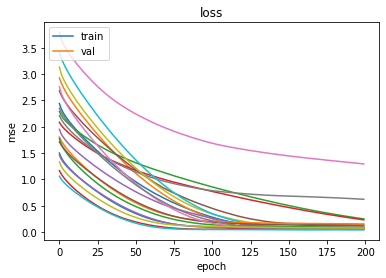

In [18]:
NB_FOLD = 10
IMAGE_BY_FOLD = len(X_train) / NB_FOLD
folds = np.arange(NB_FOLD)
folds = np.repeat(folds, IMAGE_BY_FOLD)

# just triming the rest of the division above
X_train_trim = X_train[:len(folds)]
y_train_trim = y_train[:len(folds)]

losses = []
val_losses = [] 
var_score = [] 

for i in range(NB_FOLD):
    
    train_index = folds!=i
    test_index = folds==i
    # Preparing the datasets
    Fold_train_x = X_train_trim[train_index]
    Fold_test_x  = X_train_trim[test_index]
    Fold_train_y = y_train_trim[train_index]
    Fold_test_y  = y_train_trim[test_index]
    
    print("FOLD N:", i)
    model = define_model()
    model.compile(loss = 'mse', optimizer = RMSprop(), metrics = ['mean_absolute_error'])
    history = model.fit(Fold_train_x, Fold_train_y, validation_data= (Fold_test_x, Fold_test_y), batch_size=BATCH_SIZE, epochs = 200, verbose = 1)
    losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    
    pred = model.predict(Fold_test_x) 
    
    var_score.append(explained_variance_score(Fold_test_y, pred))
    
for i in range(NB_FOLD):
    plt.plot(losses[i])
    plt.plot(val_losses[i])
    print("explained variance score for fold", str(i), ":", str(var_score[i]))
print("mean explained variance score :", np.mean(var_score))
plt.title('loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

explained variance score for fold 0 : 0.8905384377235087
explained variance score for fold 1 : 0.6018834109196649
explained variance score for fold 2 : 0.6898439427853711
explained variance score for fold 3 : -1.1014158266161536
explained variance score for fold 4 : 0.7331650077225167
explained variance score for fold 5 : 0.7019088058181513
explained variance score for fold 6 : 0.8768238772330834
explained variance score for fold 7 : 0.7514215749584343
explained variance score for fold 8 : 0.8488365836126441
explained variance score for fold 9 : 0.9089525296306156
mean explained variance score : 0.5901958343787836


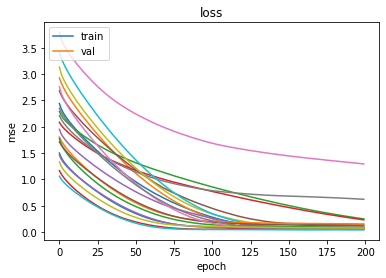

In [19]:
for i in range(NB_FOLD):
    plt.plot(losses[i])
    plt.plot(val_losses[i])
    print("explained variance score for fold", str(i), ":", str(var_score[i]))
print("mean explained variance score :", np.mean(var_score))
plt.title('loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
score = model.evaluate(X_test, y_test, verbose = 0) 
print('Test loss:', score[0]) 
print('Test mean_absolute_error:', score[1])

Test loss: 0.09868410974740982
Test mean_absolute_error: 0.21706655621528625


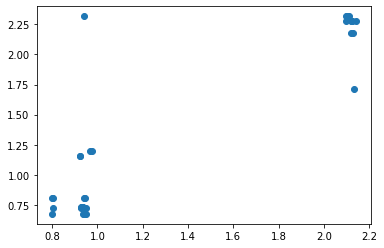

In [21]:
pred = model.predict(X_test) 
plt.scatter(pred, y_test)


In [22]:
index = range(len(pred)) 
result = {'pred': pred.flatten(),
        'true': y_test.flatten()
        }

result = pd.DataFrame(result, index = index)

result

,pred,true
0,0.934173,0.735
1,0.930252,0.735
2,2.121676,2.277
3,0.801426,0.810
4,2.103134,2.316
5,0.933159,0.735
6,0.966781,1.198
7,0.803991,0.725
8,2.134905,1.710
9,2.142831,2.277


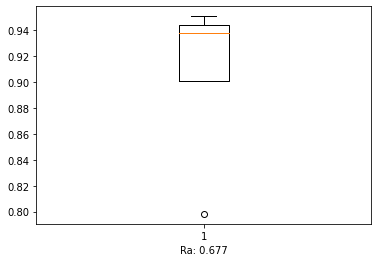

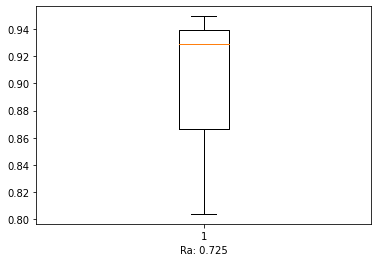

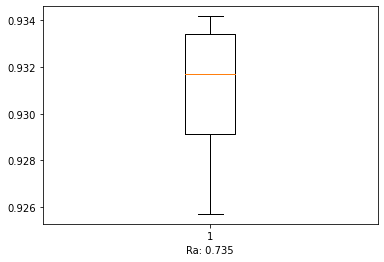

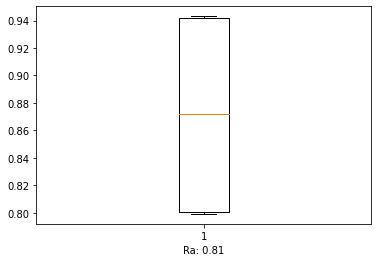

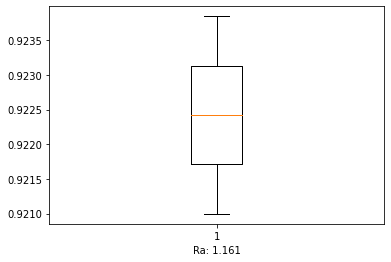

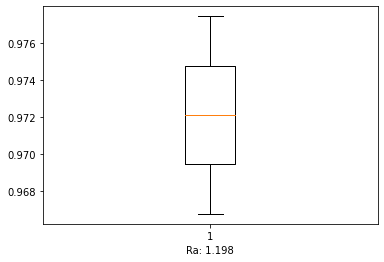

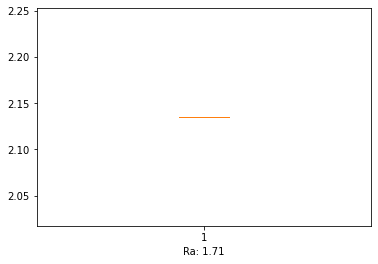

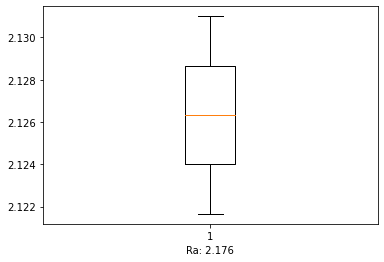

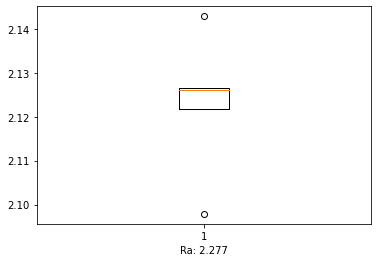

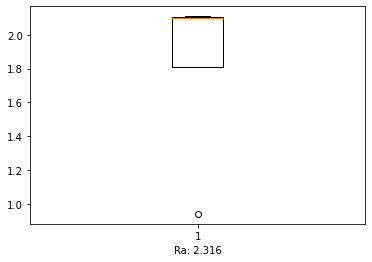

In [23]:
for value in np.unique(y):
    plt.boxplot(pred[y_test==value])
    title = "Ra: " + str(value)
    plt.xlabel(title)
    plt.show()

In [24]:
import statsmodels.api as sm
X2 = sm.add_constant(y_test)
est = sm.OLS(pred, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     121.4
Date:                Thu, 09 Jun 2022   Prob (F-statistic):           7.00e-12
Time:                        17:16:17   Log-Likelihood:                -1.5520
No. Observations:                  31   AIC:                             7.104
Df Residuals:                      29   BIC:                             9.972
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3248      0.104      3.135      0.0

In [25]:


explained_variance_score(y_test, pred)

0.8017685603393045

In [26]:
model.save('regressionReal.h5')

# Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [10]:
reg = LinearRegression().fit(X_train, y_train)

In [11]:
pred_train = reg.predict(X_train)
print("Train mean absolute error: %.2f" % mean_absolute_error(y_train, pred_train))

Train mean absolute error: 0.19


In [12]:
pred_test = reg.predict(X_test)
print("Test mean absolute error: %.2f" % mean_absolute_error(y_test, pred_test))

Test mean absolute error: 0.22


In [15]:
import pickle
print(explained_variance_score(y_test, pred_test))
pkl_filename = "regression_linear.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(reg, file)

0.7257753802036806
